In [1]:
import os
from tqdm import tqdm

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize
from statistics import mean
from sentence_transformers import SentenceTransformer
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



import pandas as pd
from catboost import Pool, CatBoostClassifier, metrics, cv
from sklearn.metrics import accuracy_score
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dzyat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dzyat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dzyat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
from sklearn.model_selection import StratifiedKFold
# from datasets import Dataset
from torch.optim import AdamW, SGD
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, get_scheduler)
import evaluate

ModuleNotFoundError: No module named 'evaluate'

In [2]:
    path = "../"
    train_data = pd.read_csv(os.path.join(path, "train.csv"))
    train_data = train_data.drop_duplicates(subset=["movie_name"], keep="last").reset_index(drop=True)
    test_data = pd.read_csv(os.path.join(path, "test.csv"))
    print(f"Number of rows and columns in the train data set: {train_data.shape}")
    print(f"Number of rows and columns in the test data set: {test_data.shape}")

Number of rows and columns in the train data set: (6944, 4)
Number of rows and columns in the test data set: (2684, 3)


movie_name                                         target  movie_description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               id                                     
#Alive                                             4       A rapidly spreading infection leaves one survivor in the entire city.                                                     

In [5]:
train_data["target"].value_counts()

4    1625
5    1590
3    1310
2    1088
1     831
0     500
Name: target, dtype: int64

In [7]:
def clean_text(text):
    
    table = text.maketrans(
        dict.fromkeys(string.punctuation))
    
    words = word_tokenize(
        text.lower().strip().translate(table))
    words = [word for word in words if word not in stopwords.words('english')]
    lemmed = [WordNetLemmatizer().lemmatize(word) for word in words]    
    return " ".join(lemmed)

In [8]:
train_data["movie_description"] = train_data["movie_description"].apply(clean_text)
test_data["movie_description"] = test_data["movie_description"].apply(clean_text)

In [6]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [9]:
embedding_train = model.encode(train_data["movie_description"])
embedding_test = model.encode(test_data["movie_description"])

In [10]:
embedding_train

array([[-0.04214927, -0.02354309, -0.06235144, ..., -0.01308155,
        -0.00519856, -0.04688659],
       [-0.03359286,  0.08724003, -0.15036741, ..., -0.00173381,
        -0.06294074,  0.03190413],
       [-0.08752245,  0.01828313, -0.02908031, ..., -0.08854064,
         0.06578239,  0.00593096],
       ...,
       [-0.09075736, -0.03913864,  0.03544707, ..., -0.04351503,
        -0.03392397, -0.04276147],
       [-0.0850934 ,  0.01014427,  0.07668772, ..., -0.01372768,
         0.03467364, -0.00594354],
       [-0.04726066, -0.07660278, -0.02821563, ..., -0.09187867,
        -0.01401786,  0.01421568]], dtype=float32)

In [12]:
df_train = pd.DataFrame(embedding_train)
df_test = pd.DataFrame(embedding_test)

In [13]:
df_train['target'] = train_data['target']
df_train['text'] = train_data['movie_description']
df_train['id'] = train_data['id']

In [15]:
df_test['text'] = test_data['movie_description']
df_test['id'] = test_data['id']

In [16]:
SEED = 1488

In [18]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,376,377,378,379,380,381,382,383,text,id
0,-0.000879,0.005213,-0.039937,0.015754,-0.052360,0.084190,-0.031520,0.042736,0.026359,0.001825,...,0.034601,0.070833,0.028698,0.018205,0.005165,-0.048211,-0.065262,0.024797,quiet western front tell gripping story young ...,133529667241314002934985813983134580070
1,-0.014230,-0.001680,-0.044496,0.040433,-0.075014,0.110258,-0.000092,-0.104477,0.012936,0.043081,...,-0.018296,0.027140,0.010112,0.047707,0.122855,-0.045129,-0.029897,-0.022189,marvel studio black panther wakanda forever qu...,133529693386607632642217219852638190950
2,-0.030206,-0.041507,0.056483,-0.047193,0.037058,-0.085644,0.016228,-0.060030,-0.043179,0.044034,...,-0.030900,0.012551,0.018353,0.027945,0.020024,-0.060898,-0.054131,0.030770,earth future global crop blight second dust bo...,133529737754378640630246272237250379110
3,-0.049118,0.032282,0.028468,0.060683,0.090984,0.040703,0.018634,-0.010158,-0.033937,-0.027064,...,-0.062608,0.042976,0.001750,0.062524,0.043615,-0.029784,-0.103719,-0.024576,adrift space food water tony stark sends messa...,133529756769137644053687294687798459750
4,-0.117073,0.034519,0.024279,-0.071363,-0.000216,0.038919,-0.020193,-0.041146,-0.086701,-0.009608,...,-0.006592,0.073914,-0.032165,-0.043739,0.043652,-0.090232,0.012489,-0.027951,streetsmart thief nathan drake tom holland rec...,133529828866765532034234504812793265510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2679,-0.015634,-0.011842,-0.004609,0.009621,-0.069253,0.044310,-0.037555,-0.111508,0.035654,-0.015355,...,0.015247,0.021554,-0.013812,0.078076,0.072134,-0.031277,0.034163,-0.072069,visiting sister naomi watt paris young woman k...,133594735746623717950164639758666530150
2680,0.012536,-0.099458,0.019961,-0.032370,-0.097632,0.042189,0.050726,-0.027228,0.033462,-0.004152,...,0.019748,0.060416,-0.007424,0.048430,0.048448,0.029668,0.007868,-0.045225,girl try play matchmaker widowed father woman ...,133594753176819471088318910338335604070
2681,-0.078795,0.050466,0.030766,-0.024256,-0.007001,0.042011,0.039817,-0.042228,-0.049884,-0.030592,...,0.032738,0.023638,-0.116682,-0.098659,0.118896,-0.076502,-0.087637,-0.025165,vacationing high school student devon werkheis...,133594873603626492770112052525140114790
2682,-0.028943,-0.020130,0.109296,0.052950,0.063360,0.050920,0.087596,-0.105823,-0.005377,0.036182,...,0.001680,0.050520,0.004252,0.073073,-0.020202,-0.069827,-0.006618,-0.026316,isabelle beauty outside becomes lost wildernes...,133594879149597868768615684073216638310


In [25]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
history = []
clfs = []
for train_index, val_index in kf.split(df_train.drop(['target'], axis=1), df_train['target']):
    train_df, val_df = df_train.iloc[train_index].reset_index(drop=True), df_train.iloc[val_index].reset_index(drop=True)
    y_train, y_val = train_df['target'], val_df['target']
    X_train, X_val = train_df.drop(['target'], axis=1), val_df.drop(['target'], axis=1)
    clf = CatBoostClassifier(
        iterations=5000,
        random_seed=SEED,
        early_stopping_rounds=300,
        task_type='GPU',
        text_features=['text'],
    )
    clf.fit(X_train, y_train, eval_set=(X_val, y_val), 
            verbose = 500, use_best_model = True, plot = False)
    clfs.append(clf)
    predictions = clf.predict(X_val)
    history.append(accuracy_score(y_val, predictions))
print(history, np.mean(history))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Warning: less than 75% gpu memory available for training. Free: 4068 Total: 6143.6875


Learning rate set to 0.061886
0:	learn: 1.5070849	test: 1.5049454	best: 1.5049454 (0)	total: 32.9ms	remaining: 2m 44s
500:	learn: 0.0120829	test: 0.0157518	best: 0.0157518 (500)	total: 10.9s	remaining: 1m 37s
1000:	learn: 0.0059599	test: 0.0127737	best: 0.0127592 (996)	total: 22.2s	remaining: 1m 28s
1500:	learn: 0.0035967	test: 0.0117313	best: 0.0117218 (1497)	total: 33.1s	remaining: 1m 17s
2000:	learn: 0.0024465	test: 0.0113392	best: 0.0113221 (1969)	total: 43.9s	remaining: 1m 5s
2500:	learn: 0.0018287	test: 0.0112502	best: 0.0112475 (2499)	total: 54.6s	remaining: 54.6s
3000:	learn: 0.0014510	test: 0.0112657	best: 0.0111606 (2802)	total: 1m 5s	remaining: 43.5s
bestTest = 0.011160637
bestIteration = 2802
Shrink model to first 2803 iterations.
Learning rate set to 0.061886


0:	learn: 1.5070794	test: 1.5092091	best: 1.5092091 (0)	total: 24.4ms	remaining: 2m 1s
500:	learn: 0.0112966	test: 0.0210775	best: 0.0210775 (500)	total: 11s	remaining: 1m 39s
1000:	learn: 0.0053625	test: 0.0179827	best: 0.0178411 (990)	total: 21.9s	remaining: 1m 27s
1500:	learn: 0.0033678	test: 0.0171231	best: 0.0170517 (1492)	total: 32.8s	remaining: 1m 16s
2000:	learn: 0.0023699	test: 0.0167595	best: 0.0167586 (1868)	total: 43.8s	remaining: 1m 5s
2500:	learn: 0.0017887	test: 0.0164648	best: 0.0164346 (2468)	total: 55.1s	remaining: 55.1s
3000:	learn: 0.0014135	test: 0.0163121	best: 0.0162767 (2935)	total: 1m 6s	remaining: 44.4s
bestTest = 0.01627668706
bestIteration = 2935
Shrink model to first 2936 iterations.
Learning rate set to 0.061886


0:	learn: 1.5075811	test: 1.5086147	best: 1.5086147 (0)	total: 34.1ms	remaining: 2m 50s
500:	learn: 0.0108547	test: 0.0227841	best: 0.0227841 (500)	total: 12.1s	remaining: 1m 48s
1000:	learn: 0.0052458	test: 0.0214680	best: 0.0214456 (784)	total: 23.8s	remaining: 1m 35s
bestTest = 0.02126105592
bestIteration = 1077
Shrink model to first 1078 iterations.
Learning rate set to 0.061886


0:	learn: 1.5070879	test: 1.5066352	best: 1.5066352 (0)	total: 26.5ms	remaining: 2m 12s
500:	learn: 0.0117986	test: 0.0179878	best: 0.0179878 (500)	total: 11.5s	remaining: 1m 43s
1000:	learn: 0.0059081	test: 0.0145662	best: 0.0145662 (1000)	total: 23.4s	remaining: 1m 33s
1500:	learn: 0.0037044	test: 0.0135430	best: 0.0135286 (1496)	total: 35s	remaining: 1m 21s
2000:	learn: 0.0025276	test: 0.0130279	best: 0.0129432 (1892)	total: 46.2s	remaining: 1m 9s
2500:	learn: 0.0018947	test: 0.0127758	best: 0.0127758 (2500)	total: 57.4s	remaining: 57.3s
3000:	learn: 0.0015082	test: 0.0125409	best: 0.0125180 (2991)	total: 1m 8s	remaining: 45.7s
3500:	learn: 0.0012303	test: 0.0126630	best: 0.0124957 (3215)	total: 1m 19s	remaining: 34.2s
bestTest = 0.01249569041
bestIteration = 3215
Shrink model to first 3216 iterations.
Learning rate set to 0.061887


0:	learn: 1.5070948	test: 1.5064379	best: 1.5064379 (0)	total: 25ms	remaining: 2m 5s
500:	learn: 0.0105358	test: 0.0209937	best: 0.0209937 (500)	total: 11.3s	remaining: 1m 41s
1000:	learn: 0.0051752	test: 0.0177816	best: 0.0177741 (999)	total: 22.6s	remaining: 1m 30s
1500:	learn: 0.0031609	test: 0.0166770	best: 0.0166499 (1498)	total: 33.9s	remaining: 1m 18s
2000:	learn: 0.0022193	test: 0.0161970	best: 0.0161789 (1998)	total: 45.1s	remaining: 1m 7s
2500:	learn: 0.0016731	test: 0.0161557	best: 0.0160917 (2273)	total: 56.8s	remaining: 56.7s
bestTest = 0.01609168204
bestIteration = 2273
Shrink model to first 2274 iterations.
[0.9964002879769619, 0.9928005759539237, 0.9928005759539237, 0.9956803455723542, 0.9920749279538905] 0.9939513426822109


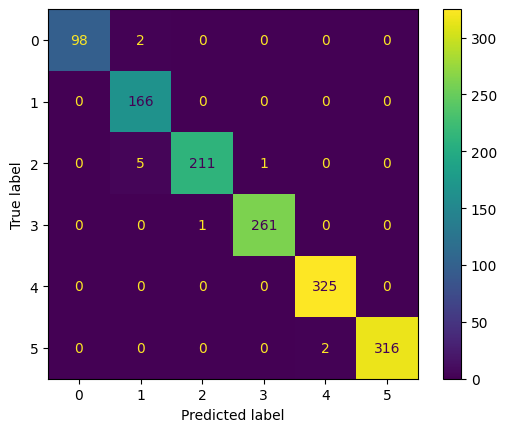

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_val, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [27]:
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [28]:
for i, clf in enumerate(clfs):
    sample_submission[i] = clf.predict(df_test)

In [29]:
sample_submission["target"] = sample_submission[[0, 1, 2, 3, 4]].mode(axis=1)[0]
sample_submission["target"] = sample_submission["target"].astype(int)
sample_submission = sample_submission[['id', 'target']]
sample_submission.to_csv("submission4.csv", index=False)